# Práctica 2
# Transformación de variables categóricas, clasificación con K Nearest Neighbor (KNN), optimización y visualización de resultados

Dataset: Bank Marketing

En esta práctica se realizará mediante un pipeline; la transformación de variables categóricas y transformaciones numéricas. Se utilizará la clase columntransformer. Posteriormente, se realizará una clasificación mediante KNN para predecir si un cliente aceptara o no el servicio de depósito a plazo fijo

Para ello, se seguirá un proceso de análisis de datos en tres fases:

* Fase 1: preparación de datos
* Fase 2: clasificación con KNN, evaluación y optimización
* Fase 3: predicción de nuevos samples (nuevos clientes)


Se diseñará el modelo mediante KNeighborsRegressor, puesto que en este ejemplo se presentará la predicción de la clase del cliente, y además se presentará la certeza (confianza o probabilidad) asociada a esa predicción. El modelo KNN con una salida continua nos proporcionará información valiosa para calcular esa certeza. Ademas se utilizará varias formas adicionales de transformación numérica mediante la clase preprocessing: normalización, L1, L2, scaling, estandarización.

Se ejecutará el modelo KNN con diferentes distancias (por ejemplo, euclidiana, manhattan, chebyshev y una personalizada) y diferentes valores de K (10, 20, 30, etc.) para evaluar y optimizar el rendimiento del modelo. Finalmente, se visualizará los resultados de los experimentos.

## Fundamentos

### Tipos de transformaciones de variables numéricas

**Normalización:**  transformación al rango entre 0 y 1

**Scaling**: transformación a umbrales mínimo y máximo (pueden ser diferentes de 0 y 1)

**Estandarización**: transformación de datos (media=0, varianza=1)

Los transformadores generalmente se combinan con clasificadores, regresores u otros estimadores para construir un estimador compuesto. La herramienta más común para combinar transformadores es un **Pipeline**.


## Algoritmo KNN

K-Nearest Neighbor (kNN) es un algoritmo de clasificación y regresión simple pero efectivo que se utiliza para asignar puntos de datos a una clase basada en la mayoría de los votos de sus k vecinos más cercanos [2]. Puede utilizarse en problemas de clasificación, donde el objetivo es predecir una categoría o etiqueta, o en problemas de regresión, donde el objetivo es predecir un valor numérico [3].

KNN es posiblemente el clasificador más intuitivo, que utiliza la distancia entre los ejemplos de entrenamiento como medida de similitud. La distancia entre los puntos representa la diferencia entre los valores de sus funciones. Dado un nuevo punto de datos, un clasificador KNN debe ver los puntos de entrenamiento más cercanos. La clase predicha para el nuevo punto será la clase más común entre los K neighbors [4].

**Pasos del KNN**:

* Calcular las distancias (con medidas de distancia o similaridad)
* Ordenar las distancias e identificar los K vecinos (elementos más cercanos)
* Calcular la decisión. En clasificación sería la clase (función de agregación clásica – el valor más frecuente). En regresión sería un   valor continuo (función de agregación clásica – el promedio).


## FASE 1: Preparación de datos

### Descripción del dataset

Nombre del dataset: Bank Marketing

Enlace : https://archive.ics.uci.edu/dataset/222/bank+marketing

Descripción:

Los datos están relacionados con campañas de marketing directo (llamadas telefónicas) de una institución bancaria portuguesa. El objetivo de la clasificación es predecir si el cliente suscribirá un depósito a plazo fijo (variable y).

Numero de variables: 17

Numero de instacias: 4521

Descripción de las variables:

Variables de entrada:
Datos del cliente bancario:
1 - Edad (numérico)

2 - Trabajo: tipo de trabajo (categórico: "admin.", "desconocido", "desempleado", "directivo", "ama de casa", "emprendedor", "estudiante", "trabajador manual", "autónomo", "jubilado", "técnico", "servicios")

3 - Estado civil: estado civil (categórico: "casado", "divorciado", "soltero"; nota: "divorciado" significa divorciado o viudo)

4 - Educación (categórico: "desconocido", "secundaria", "primaria", "terciaria")

5 - Incumplimiento: ¿tiene crédito en incumplimiento? (binario: "sí", "no")

6 - Saldo: saldo promedio anual, en euros (numérico)

7 - Vivienda: ¿tiene préstamo hipotecario? (binario: "sí", "no")

8 - Préstamo: ¿tiene préstamo personal? (binario: "sí", "no")

Relacionado con el último contacto de la campaña actual:
9 - Contacto: tipo de comunicación de contacto (categórico: "desconocido", "teléfono", "celular")

10 - Día: último día de contacto del mes (numérico)

11 - Mes: último mes de contacto del año (categórico: "ene", "feb", "mar", ..., "nov", "dic")

12 - Duración: duración del último contacto, en segundos (numérico)

Otros atributos:
13 - Campaña: número de contactos realizados durante esta campaña y para este cliente (numérico, incluye el último contacto)

14 - Pdays: número de días que transcurrieron después de que el cliente fue contactado por última vez en una campaña anterior (numérico, -1 significa que el cliente no fue contactado previamente)

15 - Anterior: número de contactos realizados antes de esta campaña y para este cliente (numérico)

16 - ResultadoPrevio: resultado de la campaña de marketing anterior (categórico: "desconocido", "otro", "fracaso", "éxito")

Variable de salida (objetivo deseado):
17 - y - ¿el cliente ha suscrito un depósito a plazo fijo? (binario: "sí", "no")

### Importación de librerias

In [1]:
from time import time
from datetime import datetime, timedelta
import pandas as pd  
import numpy as np  
from matplotlib import*
from matplotlib.cm import register_cmap
import matplotlib.pyplot as plt 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
import seaborn as sns
import copy

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier #KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
#from keras.layers import Dropout

from sklearn import metrics 
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from scipy import stats
import seaborn
from sklearn import set_config                      
print('Módulos importados')

Módulos importados


### Carga de dataset
Nombre del dataset: Statlog (German Credit Data)
Enlace: http://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)

Descripción general: Este conjunto de datos clasifica a las personas descritas por un conjunto de atributos como riesgos crediticios buenos o malos.

Número de Variables (o atributos): 21

Número de instancias (clientes en el banco): 1000

Salida: TIPOCLIENTE (BUEN CLIENTE O BAJO RIESGO:1, MAL CLIENTE O ALTO RIESGO:2)

In [2]:
# Cargar dataframe desde url de csv alojado en repositorio de github
url_dataframe = 'https://raw.githubusercontent.com/juandtap/IA_practica_01/main/bank.csv'
# el separador es una (;) y la primera fila son los encabezados (header= 0)
dfOriginal = pd.read_csv(url_dataframe, sep=';', header=0)
dataframe = copy.deepcopy(dfOriginal)
print("Tamaño del dataset: "+str(dataframe.shape[0])+" filas x "+str(dataframe.shape[1])+" columnas")
# Se muestran las 10 primeros registros
dataframe.head(10)

Tamaño del dataset: 4521 filas x 17 columnas


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
5,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341,1,330,2,other,no
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,-1,0,unknown,no
8,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,-1,0,unknown,no
9,43,services,married,primary,no,-88,yes,yes,cellular,17,apr,313,1,147,2,failure,no


### Formato a la variable de salida

La variable de salida 'y' tiene dos los valores de "yes" y "no" , para un mejor manejo de los datos, estos se convertiran a un formato binario

"no" = 0

"yes = 1

In [3]:
dataframe['y'] = dataframe['y'].map({'yes' : 1, 'no' : 0})
dataframe.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,0


### Formatos adicionales a otras variables

Otras variable con valores similares a "y" con valores de "yes" y "no" son:

"default": que indica si hubo incumplimiento de pago
"housing" : indica si tiene prestamo hipotecario (vivienda)
"loan" : indica si tiene prestamo personal
Estas variables tambien se transformaran a formato binario

In [4]:
dataframe['default'] = dataframe['default'].map({'yes' : 1, 'no' : 0})
dataframe['housing'] = dataframe['housing'].map({'yes' : 1, 'no' : 0})
dataframe['loan'] = dataframe['loan'].map({'yes' : 1, 'no' : 0})
dataframe.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,0,1787,0,0,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,0,4789,1,1,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,0,1350,1,0,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,0,1476,1,1,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,0,0,1,0,unknown,5,may,226,1,-1,0,unknown,0


### Eliminación de variables y separación de variable de salida

In [6]:
#Se separa la variable de salida "Y" para realizar la preparación de datos a las variables independiente "X" 
print(dataframe.shape)
Y=dataframe['y']
dataframe=dataframe.drop(['y'], axis=1)
# se elimina la variable "pdays", ya que tiene valores negativos que pueden afectar los resultado
dataframe=dataframe.drop(['pdays'], axis=1)
print(dataframe.shape)
dataframe.head()

(4521, 17)
(4521, 15)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome
0,30,unemployed,married,primary,0,1787,0,0,cellular,19,oct,79,1,0,unknown
1,33,services,married,secondary,0,4789,1,1,cellular,11,may,220,1,4,failure
2,35,management,single,tertiary,0,1350,1,0,cellular,16,apr,185,1,1,failure
3,30,management,married,tertiary,0,1476,1,1,unknown,3,jun,199,4,0,unknown
4,59,blue-collar,married,secondary,0,0,1,0,unknown,5,may,226,1,0,unknown


### Análisis de variables categóricas

Para buscar las variables categoricas, con la libreria pandas filtramos la columnas que son de tipo "object", no siempre las de este tipo son de tipo categoricas por ejemplo una fecha es una variable numerica

In [7]:
# Se obtiene las variables categoricas, todas las que son de tipo object
columnas_categoricas = list(dataframe.select_dtypes(include=['object']).columns)
print(columnas_categoricas)

['job', 'marital', 'education', 'contact', 'month', 'poutcome']


In [8]:
# Se obtienen las variables numéricas 
columnas_numericas = list(dataframe.select_dtypes(include=['number']).columns)
print(columnas_numericas)


['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration', 'campaign', 'previous']


In [9]:
#Determinación de tipos de variables
categorical_ordinal_features = ['education','month']
categorical_nominal_features = ['job', 'marital', 'contact','poutcome']
numeric_features = ['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration', 'campaign', 'previous']

In [10]:
def analisisVariables(dataframe, categorical_ordinal_features, categorical_nominal_features):
    cantidadTotalVariables = len(dataframe.columns) 
    print('Cantidad de variables antes de transformación de variables: ',cantidadTotalVariables)
    cantidadVariablesNominales = len(categorical_nominal_features)
    cantidadVariablesBinarias=0
    for variable in categorical_nominal_features:
        cantidadCategorias=dataframe[variable].nunique()
        cantidadVariablesBinarias=cantidadVariablesBinarias+cantidadCategorias
        print('Cantidad de categorías en la variable categórica nominal',variable,':',cantidadCategorias)
    print('Cantidad de variables binarias que reemplazarán a las variables categóricas nominales: ',cantidadVariablesBinarias)
    cantidadTotalVariablesConTransformacion = cantidadTotalVariables - cantidadVariablesNominales + cantidadVariablesBinarias
    return cantidadTotalVariablesConTransformacion

In [11]:
cantidadTotalVariablesConTransformacion=analisisVariables(dataframe, categorical_ordinal_features, categorical_nominal_features)
print('Cantidad de variables que habrá después de la transformación de variables: ',cantidadTotalVariablesConTransformacion)

Cantidad de variables antes de transformación de variables:  15
Cantidad de categorías en la variable categórica nominal job : 12
Cantidad de categorías en la variable categórica nominal marital : 3
Cantidad de categorías en la variable categórica nominal contact : 3
Cantidad de categorías en la variable categórica nominal poutcome : 4
Cantidad de variables binarias que reemplazarán a las variables categóricas nominales:  22
Cantidad de variables que habrá después de la transformación de variables:  33


Hay cuatro variables categóricas nominales: 'job','marital','contact', 'poutcome'(trabajo, estado civil, tipo de contacto, resultado contacto) Estas 4 variables categóricas nominales deben ser reemplazadas por variables binarias.

* trabajo (job): 12
* estadoCivil (marital) : 3
* tipo contacto (contact) : 3
* resultado contacto (poutcome): 4

Por lo tanto, estas 4 variables categoricas nominales serán reemplazadas por 22 variables binarias

Por lo que el dataframe luego de la transformación categórica a numérica tendrá 33 variables.


### Diseño de transformadores

Por medio de un Pipeline creamos un estimador compuesto. Esta herramienta nos permite combinar preprocesadores y transformadores para llevar un orden y estructura en el proceso de transformación de variables. Para una mejor organización creamos los preprocesadores y sus métodos de transformación.

In [12]:
#Definición de transformadores (preprocesadores)

#1. Preprocesador de variables categóricas a numéricas (ordinales y nominales)
categorical_ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())])

categorical_nominal_transformer_ConNombres = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse = False, handle_unknown = "ignore"))])# se ignorará una categoría desconocida

preprocesorCategoricoNumericoConNombres = ColumnTransformer(
    transformers=[
        ('catord', categorical_ordinal_transformer, categorical_ordinal_features),
        ('catnom', categorical_nominal_transformer_ConNombres, categorical_nominal_features)
    ],remainder='passthrough',n_jobs=-1)

#2. Normalización y Scaling: Preprocesador de variables numéricas con transformación MinMaxScaler
minmax_transformer = Pipeline(steps=[
    ('minmax', MinMaxScaler(feature_range=(0, 1)))])

preprocesorMinMax = ColumnTransformer(transformers =[
    ('tranminmax', minmax_transformer, list(range(cantidadTotalVariablesConTransformacion)))
], remainder ='passthrough')

#3. Estandarización: Preprocesador de variables numéricas con transformación StandardScaler
standardscaler_transformer = Pipeline(steps=[
    ('scaler', StandardScaler(with_mean=True,with_std=True))])
preprocesorStandardScaler = ColumnTransformer(transformers =[
    ('transcaler', standardscaler_transformer, list(range(cantidadTotalVariablesConTransformacion)))
], remainder ='passthrough')

#4. Preprocesador de variables numéricas con transformación SimpleImputer
simpleimputer_transformer = Pipeline(steps=[
    ('simpleimputer', SimpleImputer(strategy='median')) #otras: strategy='constant', strategy='most_frequent'
])
preprocesorSimpleImputer = ColumnTransformer(transformers =[
('transimpleimputer', simpleimputer_transformer, list(range(cantidadTotalVariablesConTransformacion)))
], remainder ='passthrough')

### Diseño de pipeline
El procesador ‘prepcn’ es indispensable que se aplique antes de los demás preprocesadores numéricos. En el Pipeline “pipe” se aplica primeramente la tansformación de variables categóricas a variables numéricas y en segundo lugar se aplica la transformación numérica.

In [13]:
#Construcción de Pipeline con transformadores
pipe = Pipeline(steps=[
    ('prepcn', preprocesorCategoricoNumericoConNombres), 
    #('prepstandard', preprocesorStandardScaler)
    ('prepminmax', preprocesorMinMax)
])

### Transformación de variables

In [14]:
#Se ejecuta el pipeline
dataframeTransformado=copy.deepcopy(dataframe)
X_Transformado = pipe.fit_transform(dataframeTransformado)
print('********** Pipeline aplicado')
print('********** Transformador categórico nominal:')
print(pipe.named_steps['prepcn'].transformers_[1])
#Formación de dataframe transformado
cnamesDataset1=[]
if len(categorical_ordinal_features)!=0:
    cnamesDataset1.extend(categorical_ordinal_features)
if len(categorical_nominal_features)!=0:
    #nos ubicamos primeramente en el paso "prepcn" 
    #luego, en el transformador "catnom" que está en [1] y luego en "onehot", por eso [1][1] 
    cnamesDataset2 = pipe.named_steps['prepcn'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_nominal_features)
    cnamesDataset1.extend(cnamesDataset2)
cnamesDataset3 = numeric_features
cnamesDataset1.extend(cnamesDataset3)
print('********** Lista de variables:')
print(cnamesDataset1)
dataframeTransformado = pd.DataFrame(data=X_Transformado,columns=cnamesDataset1)
#Guardar el dataset sin etiquetas como csv
#dataframeTransformado.to_csv("DatasetTransformadoSinEtiquetas.csv", sep=";",index = False)
#Se agrega la variable de salida (etiquetas) al final
dataframeTransformado = pd.concat([dataframeTransformado, Y], axis = 1)
#Guardar el dataset con etiquetas como csv
dataframeTransformado.to_csv("DatasetTransformadoConEtiquetas.csv", sep=";",index = False)
# la variable de salida 'y' e renombra como 'resultado'
dataframeTransformado.rename(columns={'y':'resultado'}, inplace=True)
dataframeTransformado.head()


********** Pipeline aplicado
********** Transformador categórico nominal:
('catnom', Pipeline(steps=[('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse=False,
                               sparse_output=False))]), ['job', 'marital', 'contact', 'poutcome'])
********** Lista de variables:
['education', 'month', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown', 'age', 'default', 'balance', 'housing', 'loan', 'day', 'duration', 'campaign', 'previous']


,education,month,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,age,default,balance,housing,loan,day,duration,campaign,previous,resultado
0,0.000000,0.909091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.161765,0.0,0.068455,0.0,0.0,0.600000,0.024826,0.000000,0.00,0
1,0.333333,0.727273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.205882,0.0,0.108750,1.0,1.0,0.333333,0.071500,0.000000,0.16,0
2,0.666667,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.235294,0.0,0.062590,1.0,0.0,0.500000,0.059914,0.000000,0.04,0
3,0.666667,0.545455,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.161765,0.0,0.064281,1.0,1.0,0.066667,0.064548,0.061224,0.00,0
4,0.333333,0.727273,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.588235,0.0,0.044469,1.0,0.0,0.133333,0.073486,0.000000,0.00,0


### Cargar y guardar Pipeline o Modelo

In [15]:
# Funciones para guardar y cargar un Pipeline o Modelo
def guardarPipeline(pipeline,nombreArchivo):
    with open(nombreArchivo+'.pickle', 'wb') as handle:
        pickle.dump(pipeline, handle, protocol=pickle.HIGHEST_PROTOCOL)

def cargarPipeline(nombreArchivo):
    with open(nombreArchivo+'.pickle', 'rb') as handle:
        pipeline = pickle.load(handle)
    return pipeline

In [16]:
guardarPipeline(pipe,'pipePreprocesadores')
pipe=None
pipe=cargarPipeline('pipePreprocesadores')
set_config(display='diagram')
pipe

Pipeline(steps=[('prepcn',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('catord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['education', 'month']),
                                                 ('catnom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['job', 'marital', 'contact',
                                                   'poutcome'])])),
                ('prepminmax',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tranminmax',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, ...])]))])

### Análisis de correlación

En esta subsección se realiza un mapa de calor de las correlaciones entre todas las variables para identificar las variables más relevantes e influyentes a la variable de salida.

In [17]:
dfCorrel=copy.deepcopy(dataframeTransformado)
dfCorrel=dfCorrel.corr()
dfCorrel.head()

,education,month,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,age,default,balance,housing,loan,day,duration,campaign,previous,resultado
education,1.000000,-0.050086,-0.040924,-0.358711,0.047063,-0.096775,0.416006,-0.099783,0.057957,-0.081151,...,-0.121613,-0.010534,0.057725,-0.087070,-0.054086,0.014926,-0.014878,-0.001723,0.023983,0.042987
month,-0.050086,1.000000,0.030382,0.091103,0.048005,-0.035309,-0.055187,-0.026899,0.008655,0.051113,...,-0.040714,0.014297,0.023113,0.266630,0.016329,-0.014795,0.000851,-0.108915,0.046899,-0.040933
job_admin.,-0.040924,0.030382,1.000000,-0.176876,-0.067550,-0.054803,-0.179592,-0.079606,-0.070622,-0.109604,...,-0.048385,-0.011389,-0.022386,0.045632,0.035866,0.017052,-0.038763,-0.017895,0.020665,0.006568
job_blue-collar,-0.358711,0.091103,-0.176876,1.000000,-0.101057,-0.081987,-0.268679,-0.119095,-0.105655,-0.163973,...,-0.049307,-0.008048,-0.057691,0.175040,0.017244,-0.027025,0.028114,0.008783,-0.014861,-0.068147
job_entrepreneur,0.047063,0.048005,-0.067550,-0.101057,1.000000,-0.031311,-0.102609,-0.045483,-0.040350,-0.062622,...,0.015638,0.037983,0.014523,-0.002577,0.049794,-0.015707,0.016267,-0.012910,-0.013226,-0.015968


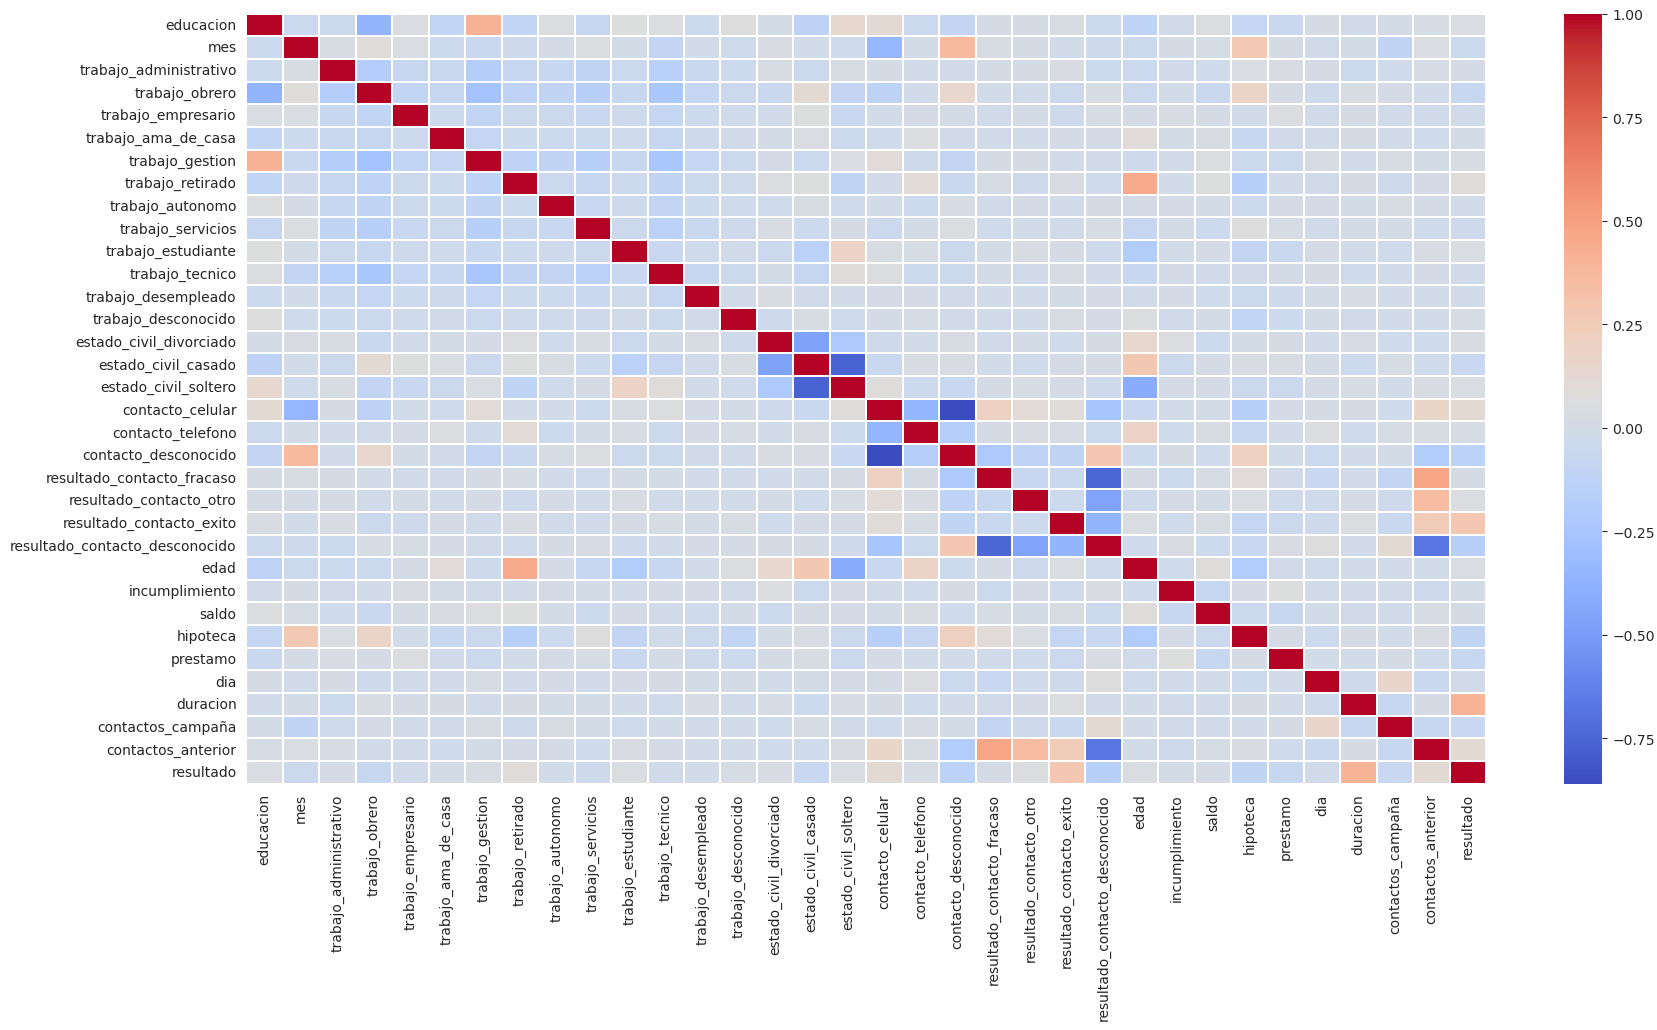

In [18]:
#Generar el mapa de calor de las correlaciones
mask = np.zeros_like(dfCorrel)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 10))
    #ax = sns.heatmap(dfCorrel, mask=mask, square=True, linewidths=.5, cmap="YlGnBu")
    #ax = sns.heatmap(dfCorrel, cmap ='viridis', linewidths = 0.30, annot = False)
    #ax = sns.heatmap(dfCorrel, cmap ='GnBu', linewidths = 0.30, annot = False)
    #ax = sns.heatmap(dfCorrel, cmap ='YlGnBu', linewidths = 0.30, annot = False)
    ax = sns.heatmap(dfCorrel, cmap='coolwarm', linewidths=0.30, annot=False)
#plt.savefig('attribute_correlations.png')
nuevas_etiquetas_x = ['educacion', 'mes', 'trabajo_administrativo', 'trabajo_obrero', 'trabajo_empresario','trabajo_ama_de_casa','trabajo_gestion','trabajo_retirado', 'trabajo_autonomo',
                      'trabajo_servicios', 'trabajo_estudiante','trabajo_tecnico','trabajo_desempleado','trabajo_desconocido','estado_civil_divorciado','estado_civil_casado','estado_civil_soltero',
                      'contacto_celular','contacto_telefono','contacto_desconocido','resultado_contacto_fracaso','resultado_contacto_otro','resultado_contacto_exito','resultado_contacto_desconocido',
                      'edad', 'incumplimiento', 'saldo', 'hipoteca', 'prestamo','dia','duracion','contactos_campaña','contactos_anterior', 'resultado']
nuevas_etiquetas_y = nuevas_etiquetas_x
ax.set_xticklabels(nuevas_etiquetas_x, rotation=90)
ax.set_yticklabels(nuevas_etiquetas_y)
plt.show()


### Se presenta las variables más correlacionadas positivamente con respecto a la variable de salida 

In [19]:

dfCorrOrdenado=dfCorrel.sort_values(by=['resultado'], ascending=False)
dfCorrOrdenado['resultado'].head(10)#Se presenta las variables más correlacionadas positivamente con respecto a la variable de salida 


resultado           1.000000
duration            0.401118
poutcome_success    0.283481
contact_cellular    0.118761
previous            0.116714
job_retired         0.086675
poutcome_other      0.051908
job_student         0.047809
marital_single      0.045815
age                 0.045092
Name: resultado, dtype: float64

### Se presenta las variables más correlacionadas negativamente con respecto a la variable de salida

In [20]:
dfCorrOrdenado=dfCorrel.sort_values(by=['resultado'], ascending=True)
dfCorrOrdenado['resultado'].head(10)

poutcome_unknown   -0.162038
contact_unknown    -0.139399
housing            -0.104683
loan               -0.070517
job_blue-collar    -0.068147
marital_married    -0.064643
campaign           -0.061147
month              -0.040933
job_services       -0.024071
job_entrepreneur   -0.015968
Name: resultado, dtype: float64

### Selección y extracción de variables
Se seleccionan las variables con mayor correlación.

In [21]:
dataframeExtraccion=dataframeTransformado[['resultado','age','balance','duration','poutcome_success', 'contact_cellular','job_student','marital_single']]
print(dataframeExtraccion.shape)
dataframeExtraccion.head()

(4521, 8)


,resultado,age,balance,duration,poutcome_success,contact_cellular,job_student,marital_single
0,0,0.161765,0.068455,0.024826,0.0,1.0,0.0,0.0
1,0,0.205882,0.108750,0.071500,0.0,1.0,0.0,0.0
2,0,0.235294,0.062590,0.059914,0.0,1.0,0.0,1.0
3,0,0.161765,0.064281,0.064548,0.0,0.0,0.0,0.0
4,0,0.588235,0.044469,0.073486,0.0,0.0,0.0,0.0


### Generar todas las figuras de correlaciones entre cada par de variables

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


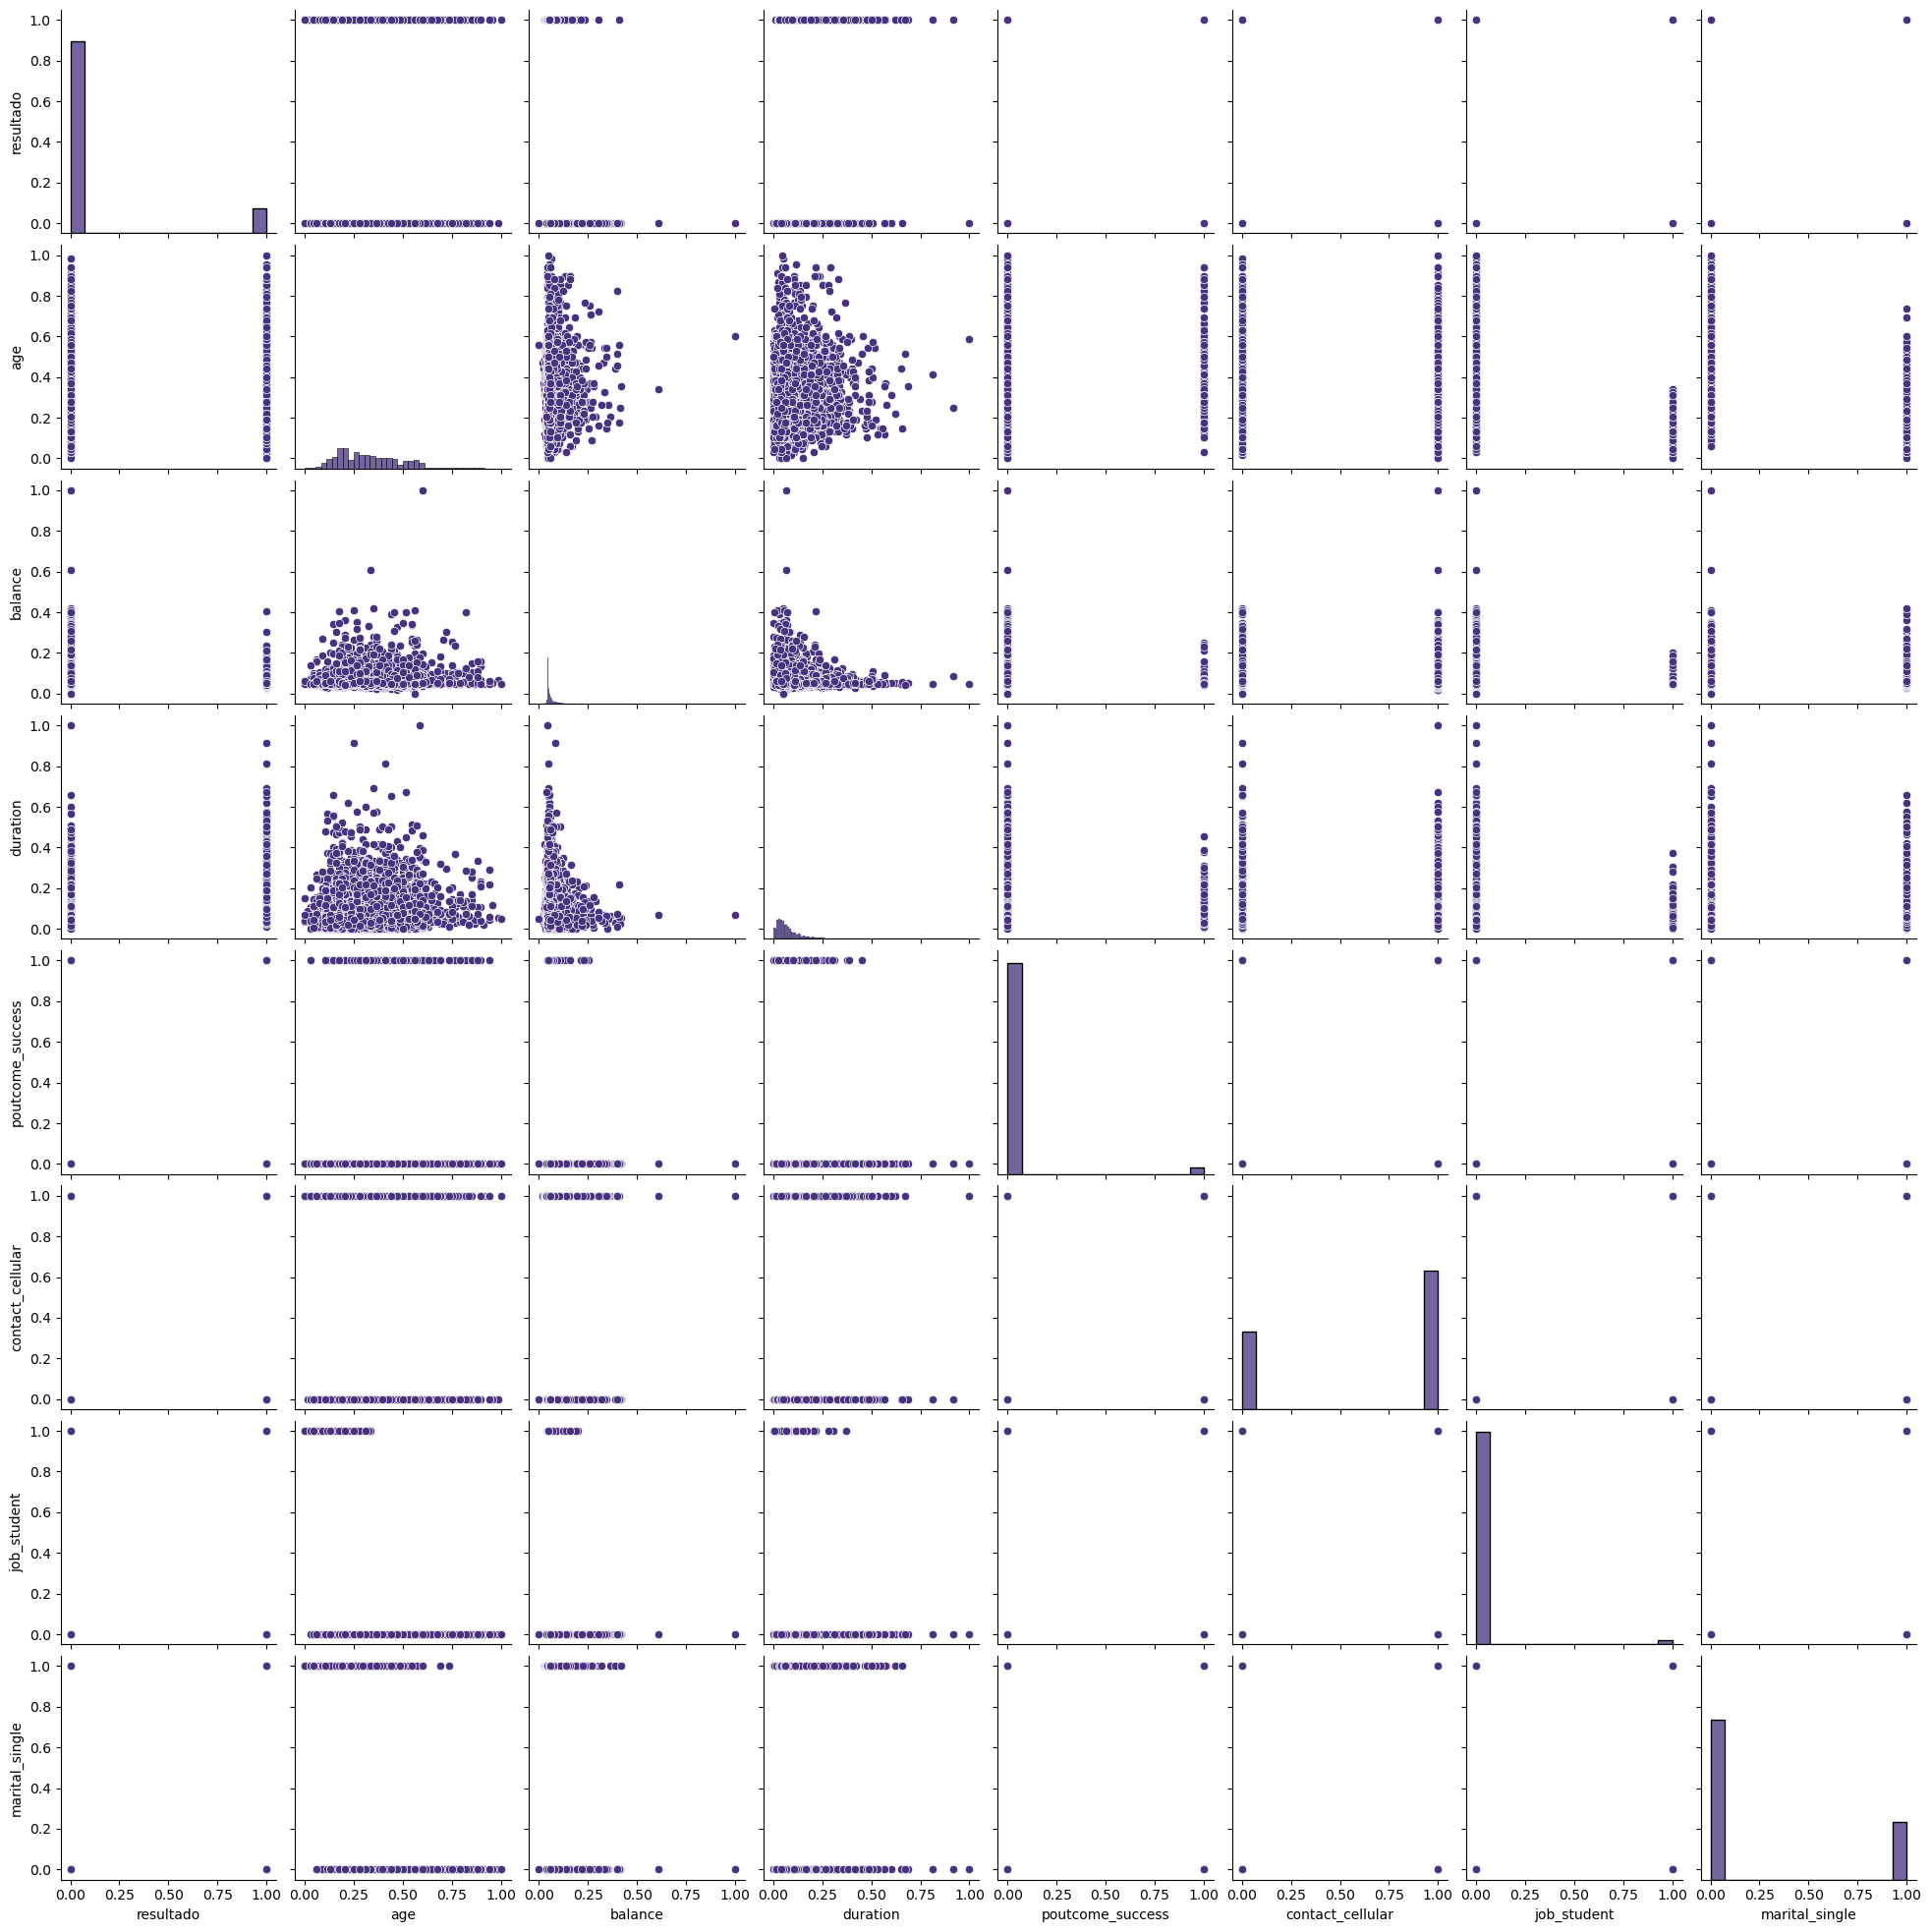

In [22]:
sns.set_palette("viridis")
sns.pairplot(dataframeExtraccion)
plt.show()

### Transformación numérica adicional: Min max scaling

In [23]:
from sklearn import preprocessing
dataframeExtraccion=dataframeExtraccion.drop(['resultado'], axis=1)


In [24]:
data_scaler_minmax = preprocessing.MinMaxScaler(feature_range=(0, 1))
data_scaled_minmax = data_scaler_minmax.fit_transform(dataframeExtraccion)
print("\nDatos normalizados con escala Min Max:\n")
DataframeTransformado1 = pd.DataFrame(data=data_scaled_minmax,columns=dataframeExtraccion.columns)
DataframeTransformado1 = pd.concat([DataframeTransformado1, dataframeTransformado[['resultado']]], axis = 1)
#DataframeTransformado1.to_csv("DatasetBankMarketingTransformadoMinMax.csv", sep=";",index = False) 
DataframeTransformado1.head()


Datos normalizados con escala Min Max:



,age,balance,duration,poutcome_success,contact_cellular,job_student,marital_single,resultado
0,0.161765,0.068455,0.024826,0.0,1.0,0.0,0.0,0
1,0.205882,0.108750,0.071500,0.0,1.0,0.0,0.0,0
2,0.235294,0.062590,0.059914,0.0,1.0,0.0,1.0,0
3,0.161765,0.064281,0.064548,0.0,0.0,0.0,0.0,0
4,0.588235,0.044469,0.073486,0.0,0.0,0.0,0.0,0


### Transformación numérica adicional: Normalización L1 y L2

In [25]:
#Normalización L1: la suma de los valores absolutos es igual a 1
data_normalized_l1 = preprocessing.normalize(dataframeExtraccion, norm='l1')
#Normalización L2: la suma de los cuadrados es igual a 1
data_normalized_l2 = preprocessing.normalize(dataframeExtraccion, norm='l2')
print("\nDatos normalizados con L2:\n")

DataframeTransformado2 = pd.DataFrame(data=data_normalized_l1,columns=dataframeExtraccion.columns)
DataframeTransformado2 = pd.concat([DataframeTransformado2, dataframeTransformado[['resultado']]], axis = 1)
#DataframeTransformado2.to_csv("DatasetBancoTransformadoNormL1.csv", sep=";",index = False)
DataframeTransformado2.head(10)

#DataframeTransformado3 = pd.DataFrame(data=data_normalized_l2,columns=dataframeExtraccion.columns)
#DataframeTransformado3 = pd.concat([DataframeTransformado3, dataframeTransformado[['resultado']]], axis = 1)
#DataframeTransformado3.to_csv("DatasetBancoTransformadoNormL2.csv", sep=";",index = False)
#DataframeTransformado3.head()


Datos normalizados con L2:



,age,balance,duration,poutcome_success,contact_cellular,job_student,marital_single,resultado
0,0.128891,0.054544,0.019781,0.0,0.796783,0.0,0.000000,0
1,0.148530,0.078456,0.051582,0.0,0.721432,0.0,0.000000,0
2,0.099794,0.026546,0.025411,0.0,0.424125,0.0,0.424125,0
3,0.556669,0.221206,0.222125,0.0,0.000000,0.0,0.000000,0
4,0.832970,0.062971,0.104059,0.0,0.000000,0.0,0.000000,0
5,0.100762,0.023337,0.019420,0.0,0.428240,0.0,0.428240,0
6,0.177287,0.034457,0.079107,0.0,0.709148,0.0,0.000000,0
7,0.211714,0.033431,0.035026,0.0,0.719829,0.0,0.000000,0
8,0.832747,0.122097,0.045157,0.0,0.000000,0.0,0.000000,0
9,0.235528,0.028887,0.068257,0.0,0.667328,0.0,0.000000,0


### Transformación numérica adicional: Estandarización

In [26]:
XEstandarizado = preprocessing.scale(dataframeExtraccion)
print("\nDatos estandarizados:\n")

DataframeTransformado4 = pd.DataFrame(data=XEstandarizado,columns=dataframeExtraccion.columns)
DataframeTransformado4 = pd.concat([DataframeTransformado4, dataframeTransformado[['resultado']]], axis = 1)
#DataframeTransformado4.to_csv("DatasetBancoTransformadoScale.csv", sep=";",index = False)
DataframeTransformado4.head()


Datos estandarizados:



,age,balance,duration,poutcome_success,contact_cellular,job_student,marital_single,resultado
0,-1.056270,0.121072,-0.711861,-0.171381,0.749079,-0.137593,-0.599749,0
1,-0.772583,1.118644,-0.169194,-0.171381,0.749079,-0.137593,-0.599749,0
2,-0.583458,-0.024144,-0.303898,-0.171381,0.749079,-0.137593,1.667363,0
3,-1.056270,0.017726,-0.250017,-0.171381,-1.334973,-0.137593,-0.599749,0
4,1.686036,-0.472753,-0.146102,-0.171381,-1.334973,-0.137593,-0.599749,0


### Transformación de nuevos samples
La siguiente función permite transformar las variables de un nuevo cliente a un formato numérico. En la función se define el valor por defecto de las variables, se crea el dataframe con los nuevos valores y los nombres de las variables. Luego, se aplica la transformación de variables mediante el Pipeline.

In [27]:
def preprocesarNuevoCliente(age=40, job='management', marital='married', education='tertiary',
                            default=0, balance=5000, housing=0, loan=0, contact='cellular', day=10, month='oct',duration='60', campaign=1,previous=0,
                            poutcome='unknown'):    
    cnames=['age', 'job','marital', 'education',
                            'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month','duration', 'campaign','previous',
                            'poutcome']
    Xnew=[age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, previous, poutcome]
    Xnew_Dataframe = pd.DataFrame(data=[Xnew],columns=cnames)
    Xnew_Preprocesado = pipe.transform(Xnew_Dataframe)
    return Xnew_Preprocesado

age=40
job='management'
marital='married'
education='tertiary'
default=0 
balance=5000
housing=0
loan=0
contact='cellular'
day=10
month='oct'
duration='60'
campaign=1
previous=0
poutcome='unknown'

Xnew_Preprocesado=preprocesarNuevoCliente(age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, previous, poutcome)
Xnew_Preprocesado

array([[0.66666667, 0.90909091, 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.30882353,
        0.        , 0.11158239, 0.        , 0.        , 0.3       ,
        0.01853691, 0.        , 0.        ]])

## Fase 2: Clasificación con el algoritmo KNN, evaluación y optimización

### Carga del dataset

A partir de la carga del dataset transformado se proceder con la fase de clasificación. Para ello, se debe indicar el csv deseado.

In [28]:
dataframeTransformado=pd.read_csv("DatasetTransformadoConEtiquetas.csv", sep=";")
dataframeTransformado.rename(columns={'y':'resultado'}, inplace=True)
print(dataframeTransformado.shape)
dataframeTransformado.head()

(4521, 34)


,education,month,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,age,default,balance,housing,loan,day,duration,campaign,previous,resultado
0,0.000000,0.909091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.161765,0.0,0.068455,0.0,0.0,0.600000,0.024826,0.000000,0.00,0
1,0.333333,0.727273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.205882,0.0,0.108750,1.0,1.0,0.333333,0.071500,0.000000,0.16,0
2,0.666667,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.235294,0.0,0.062590,1.0,0.0,0.500000,0.059914,0.000000,0.04,0
3,0.666667,0.545455,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.161765,0.0,0.064281,1.0,1.0,0.066667,0.064548,0.061224,0.00,0
4,0.333333,0.727273,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.588235,0.0,0.044469,1.0,0.0,0.133333,0.073486,0.000000,0.00,0


### Guardar modelo

In [29]:
# Función para guardar un modelo
def guardarModelo(pipeline,nombreArchivo):
    with open(nombreArchivo+'.pickle', 'wb') as handle:
        pickle.dump(pipeline, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("********** Pickle guardado")

# Función para transformar la predicción         
def transformarPrediccion(lista):
    for i in range(len(lista)):
        desempenio=lista[i]
        #print(desempenio)
        if (desempenio < 0.5):
            desempenio = 0
        elif (desempenio >= 0.5):
            desempenio = 1
        lista[i]=desempenio
    return lista

In [30]:
Y = dataframeTransformado['resultado']
dataframeTransformado=dataframeTransformado.drop(['resultado'], axis=1)
X_Transformado=dataframeTransformado.values
X_Transformado

array([[0.        , 0.90909091, 0.        , ..., 0.02482622, 0.        ,
        0.        ],
       [0.33333333, 0.72727273, 0.        , ..., 0.0714995 , 0.        ,
        0.16      ],
       [0.66666667, 0.        , 0.        , ..., 0.05991394, 0.        ,
        0.04      ],
       ...,
       [0.33333333, 0.09090909, 0.        , ..., 0.04865938, 0.20408163,
        0.        ],
       [0.33333333, 0.27272727, 0.        , ..., 0.04137703, 0.06122449,
        0.12      ],
       [0.66666667, 0.        , 0.        , ..., 0.11287653, 0.02040816,
        0.28      ]])

### Diseño y optimización

En esta sección se evalúa el método KNN con distintos valores de parámetros. El código itera a través de diferentes distancias (por ejemplo, euclidiana, manhattan, chebyshev y una personalizada) y diferentes valores de K (10, 20, 30, etc.) para evaluar el rendimiento del modelo. Se calculan varias métricas de rendimiento, como: Error Absoluto Medio (MAE), Error Cuadrático Medio (MSE), Raíz del Error Cuadrático Medio (RMSE), Accuracy (ACC), Precision, Recall (Sensibilidad) y F1-Score. Estas métricas miden el rendimiento del modelo en la clasificación de datos. Se ejecuta N experimentos por cada valor de K. Luego, se calcula el promedio de los N experimentos.

**Distancia personalizada**

Como distancia personalizada se tiene una variación de la distancia de Minkowsky, especificamente el parametro r lo definimos en 2

$MiDistancia =  \sqrt{\left( |p[0] - q[0]|^2 + |p[1] - q[1]|^2 \right)}$

Como segunda distancia personalizada se tiene un promedio de la suma de la distancia euclidiana y la de manhattan, cada una de estas tienen unos parametros $\alpha$ y $\beta$

$MiDistancia2 = ( alpha * euclidianDistance  +   beta * manhattanDistance) / 2$


In [31]:
# Distancia personalizada

# def distancia_personalizada(p, q):
#     # parametro Minkowsky r = 2
#     r = 2
#     distance = (abs(p[0] - q[0]) ** r + abs(p[1] - q[1]) ** r) ** (1 / r)
#     return distance

def distancia_personalizada(p, q):

    alpha = 0.81
    beta = 0.85
    # Distancia de Manhattan
    manhattan_distance = abs(p[0] - q[0]) + abs(p[1] - q[1])
    
    # Distancia Euclidiana
    euclidean_distance = np.sqrt((p[0] - q[0])**2 + (p[1] - q[1])**2)
    
    # Distancia combinada
    distance = (alpha * manhattan_distance + beta * euclidean_distance)/2
    
    return distance


In [32]:
# Crear un DataFrame vacío con las columnas deseadas
columnas = ['DISTANCE','K','ACC','PRECISION','RECALL','F1-SCORE']
# Definr el tipo de dato de cada columna
tipos_de_variable = [str, int, float, float, float, float]
# Crear un dataframe vacío, a este dataframe se agregarán fila a fila los resultados de KNN
dataResultados = pd.DataFrame(columns=columnas)
model=None
# Definir las distancias a calcular
DISTANCE=['euclidean','manhattan','chebyshev','propia']
# Definir los valores de K (la cantidad de vecinos que conforman el vecindario)
K=[10,20,30,40,50,60,70,80,90,100]
valoresK=K
# Definir la cantidad de experimentos que se repiten por cada valor de K. Luego, se calculará el promedio de nExperimentos
nExperimentos=10
for idexp in range(nExperimentos):
    # Crear las particiones del conjunto de datos. De manera convencional, el conjunto de test contiene el 20% de los datos.
    X_train, X_test, y_train, y_test = train_test_split(X_Transformado, Y, test_size = 0.2)
    for d in DISTANCE:
        for k in K:
            # Llamar a la función personalizada
            if d=='propia':
                model=KNeighborsClassifier(n_neighbors=k, metric=distancia_personalizada)
            else:
                model=KNeighborsClassifier(n_neighbors=k, metric=d)#clásicas: euclidean,manhattan,minkowski,chebyshev
            # Entrenar el modelo
            history = model.fit(X_train, y_train)
            # Calcular predicciones para el conjunto de Test
            y_pred = model.predict(X_test)
            y_pred = y_pred.flatten()
            # Transformar salida continua a discreta (binaria)
            y_pred = transformarPrediccion(y_pred)
            # Evaluar el modelo con medidas de calidad
            MAE=metrics.mean_absolute_error(y_test, y_pred)
            MSE=metrics.mean_squared_error(y_test, y_pred)
            RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
            y_testBinario = (y_test >= 0.5).astype("int32")
            y_predBinario = (y_pred >= 0.5).astype("int32")
            ACC=float(str(accuracy_score(y_testBinario, y_predBinario)))
            precision=precision_score(y_testBinario, y_predBinario)
            recall=recall_score(y_testBinario, y_predBinario)
            f1=f1_score(y_testBinario, y_predBinario)
            MAE=float(str(round(MAE, 4)))
            MSE=float(str(round(MSE, 4)))
            RMSE=float(str(round(RMSE, 4)))
            precision=float(str(round(precision, 4)))
            recall=float(str(round(recall, 4)))
            f1=float(str(round(f1, 4)))
            valor=[d,k,ACC,precision,recall,f1]
            # print(valor)
            fila = pd.Series(valor, index=columnas)
            # Agregar los resultados en el dataframe
            dataResultados = pd.concat([dataResultados, fila.to_frame().T], ignore_index=True)
# Convertir el tipo de datos de cada columna 
dataResultados['K'] = dataResultados['K'].astype(int)
dataResultados['ACC'] = dataResultados['ACC'].astype(float)
dataResultados['PRECISION'] = dataResultados['PRECISION'].astype(float)
dataResultados['RECALL'] = dataResultados['RECALL'].astype(float)
dataResultados['F1-SCORE'] = dataResultados['F1-SCORE'].astype(float)
dataResultados = dataResultados.sort_values(by=['DISTANCE','K'])
dataResultados = dataResultados.reset_index(drop=True)
dataResultados.head(100)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision 

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.893923,0.3333,0.0105,0.0204
1,chebyshev,10,0.906077,0.7500,0.0345,0.0659
2,chebyshev,10,0.882873,1.0000,0.0185,0.0364
3,chebyshev,10,0.889503,1.0000,0.0291,0.0566
4,chebyshev,10,0.881768,0.2857,0.0396,0.0696
...,...,...,...,...,...,...
95,chebyshev,100,0.891713,0.0000,0.0000,0.0000
96,chebyshev,100,0.887293,0.0000,0.0000,0.0000
97,chebyshev,100,0.897238,0.0000,0.0000,0.0000
98,chebyshev,100,0.896133,0.0000,0.0000,0.0000


### Filtro de resultados
Filtrar por algunos valores de k

In [33]:

valoresK=[10,20,30,40,50,60,70,80,90,100]
#Nmin=10
#Nmax=40
#dataResultados=dataResultados.loc[(dataResultados['K'] >= Nmin) & (dataResultados['K'] <= Nmax)]
dataResultados=dataResultados.loc[(dataResultados['K'].isin(valoresK))]
dataResultados.head(100)

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.893923,0.3333,0.0105,0.0204
1,chebyshev,10,0.906077,0.7500,0.0345,0.0659
2,chebyshev,10,0.882873,1.0000,0.0185,0.0364
3,chebyshev,10,0.889503,1.0000,0.0291,0.0566
4,chebyshev,10,0.881768,0.2857,0.0396,0.0696
...,...,...,...,...,...,...
95,chebyshev,100,0.891713,0.0000,0.0000,0.0000
96,chebyshev,100,0.887293,0.0000,0.0000,0.0000
97,chebyshev,100,0.897238,0.0000,0.0000,0.0000
98,chebyshev,100,0.896133,0.0000,0.0000,0.0000


### Agrupar resultados por medida de distancia y cantidad de vecinos (K)

Se agrupa los resultados por medida de distancia y cantidad de vecinos. Se puede apreciar los resultados de N experimentos por cada valor de K.

In [34]:
dataResultados = dataResultados.groupby(['DISTANCE','K'])
dataResultados.head(5)


,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.893923,0.3333,0.0105,0.0204
1,chebyshev,10,0.906077,0.7500,0.0345,0.0659
2,chebyshev,10,0.882873,1.0000,0.0185,0.0364
3,chebyshev,10,0.889503,1.0000,0.0291,0.0566
4,chebyshev,10,0.881768,0.2857,0.0396,0.0696
...,...,...,...,...,...,...
390,propia,100,0.895028,0.0000,0.0000,0.0000
391,propia,100,0.903867,0.0000,0.0000,0.0000
392,propia,100,0.880663,0.0000,0.0000,0.0000
393,propia,100,0.886188,0.0000,0.0000,0.0000


### Calculo de los N experimentos
Se procede a calcular el promedio de los N experimentos

In [35]:
dataResultados = dataResultados.mean()
dataResultados = dataResultados.reset_index()
dataResultados = dataResultados.reset_index(drop=True)
dataResultados = dataResultados.groupby(['DISTANCE'])
dataResultados.head(5)

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.890939,0.75190,0.02785,0.05309
1,chebyshev,20,0.890276,0.30000,0.00518,0.01017
2,chebyshev,30,0.889724,0.00000,0.00000,0.00000
3,chebyshev,40,0.889724,0.00000,0.00000,0.00000
4,chebyshev,50,0.889724,0.00000,0.00000,0.00000
10,euclidean,10,0.892376,0.63379,0.07031,0.12552
11,euclidean,20,0.893591,0.74440,0.05524,0.10231
12,euclidean,30,0.892486,0.78738,0.03414,0.06509
13,euclidean,40,0.890829,0.63167,0.02002,0.03863
14,euclidean,50,0.889834,0.47334,0.01413,0.02734


### Visualización de resultados

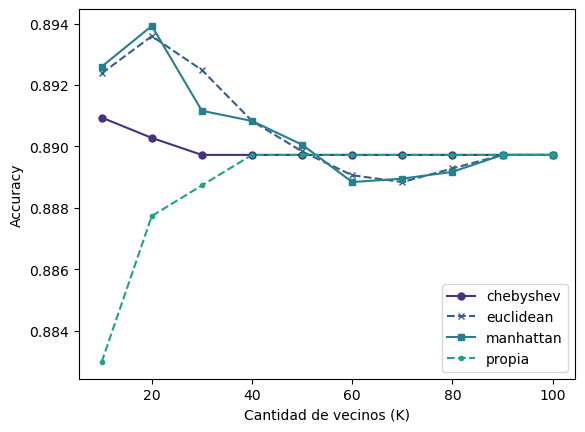

In [38]:
for name in dataResultados.groups.keys():
    group = dataResultados.get_group(name)
    #print(name)
    valores=group.ACC.values.tolist()
    #print(valores)
    #SIN EFECTO SUAVIZADO
    if name=='euclidean': plt.plot(valoresK, valores, marker='x', linestyle='--', color='C1', ms=5, label = name) 
    if name=='manhattan': plt.plot(valoresK, valores, marker='s', linestyle='-', color='C2', ms=5, label = name)    
    if name=='propia': plt.plot(valoresK, valores, marker='o', linestyle='--', color='C9', ms=3, label = name)
    if name=='chebyshev': plt.plot(valoresK, valores, marker='.', linestyle='-', color='C0', ms=10, label = name)
    #plt.title("Resultados")
    plt.xlabel("Cantidad de vecinos (K)")   # Inserta el título del eje X 
    plt.ylabel("Accuracy")   # Inserta el título del eje Y
    plt.legend(loc="lower right")

Se agrega un efecto suavizado (creación de curvas de ajuste) y más puntos mediante una interpolación. La interpolación es un proceso matemático que implica estimar valores desconocidos o faltantes entre dos o más puntos de datos conocidos. Se utiliza para crear una función suave que pase a través de los puntos de datos existentes y permita predecir o estimar valores para ubicaciones o puntos intermedios.

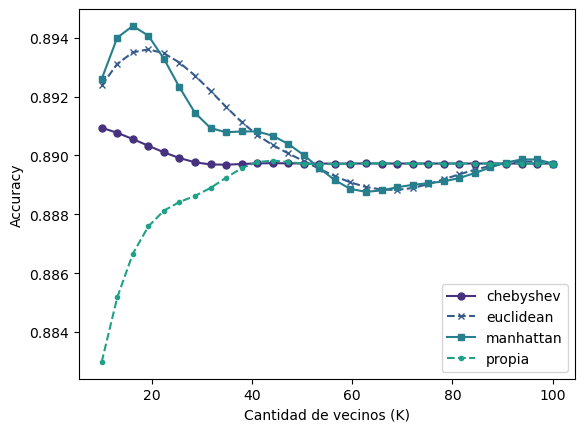

In [39]:
from scipy.interpolate import make_interp_spline, BSpline 
for name in dataResultados.groups.keys():
    group = dataResultados.get_group(name)
    #print(name)
    valores=group.ACC.values.tolist()
    #print(valores)
    #EFECTO SUAVIZADO: GENERAR PUNTOS CON UNA REGRESIÓN ENTRE LOS VALORES QUE TENEMOS
    numeroPuntos=len(valoresK)*3  #representa el número de puntos para generar entre T.min and T.max 
    xnew = np.linspace(min(valoresK),max(valoresK),numeroPuntos) #linspace genera puntos en un rango
    spl = make_interp_spline(valoresK, valores, k=3) #BSpline object 
    power_smooth = spl(xnew)         
    if name=='euclidean': plt.plot(xnew, power_smooth, marker='x', linestyle='--', color='C1', ms=5, label = name) 
    if name=='manhattan': plt.plot(xnew, power_smooth, marker='s', linestyle='-', color='C2', ms=5, label = name)    
    if name=='propia': plt.plot(xnew, power_smooth, marker='o', linestyle='--', color='C9', ms=3, label = name)
    if name=='chebyshev': plt.plot(xnew, power_smooth, marker='.', linestyle='-', color='C0', ms=10, label = name) 
        
    #plt.title("Resultados")
    plt.xlabel("Cantidad de vecinos (K)")   # Inserta el título del eje X 
    plt.ylabel("Accuracy")   # Inserta el título del eje Y
    plt.legend(loc="lower right")

### Diseño y entrenamiento del modelo optimizado

In [40]:
#Construcción de modelo KNN
model=KNeighborsRegressor(n_neighbors=25, metric='manhattan')#euclidean,manhattan,minkowski,chebyshev 
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_Transformado, Y, test_size = 0.2)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
history = model.fit(X_train, y_train)
print('Modelo entrenado')
#Se guarda el modelo entrenado
guardarModelo(model,'modeloKNN')
print('Modelo Optimizado Guardado')

(3616, 33) (3616,)
(905, 33) (905,)
Modelo entrenado
********** Pickle guardado
Modelo Optimizado Guardado


### Predicción con el conjunto de Test

In [41]:
#Predicciones
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()
y_pred = transformarPrediccion(y_pred)
dataframeFinal=pd.DataFrame({'real':y_test, 'predicción clase': y_pred})
np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})
dataframeFinal.head(10)

,real,predicción clase
1023,0,0.0
1172,0,0.0
278,0,0.0
837,1,0.0
66,0,0.0
4125,1,0.0
2824,0,0.0
3394,1,0.0
2300,0,0.0
2550,0,0.0


### Evaluación de la calidad del modelo

Mean Absolute Error (MAE): 0.1215
Mean Squared Error (MSE): 0.1215
Root Mean Squared Error (RMSE): 0.3486
Accuracy: 0.8784530386740331
Precision:  0.5
Recall:  0.0273
F1: 0.0517
Matriz de confusión:
Verdaderos negativos:  792  Falsos positivos:  3  Falsos negativos:  107  Verdaderos positivos:  3


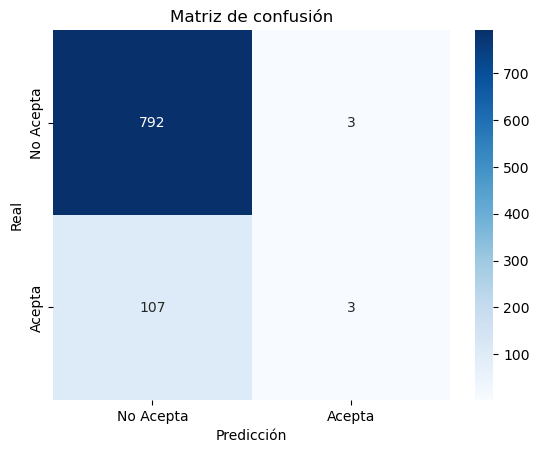

In [42]:
MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)  
print('Mean Squared Error (MSE):', MSE)  
print('Root Mean Squared Error (RMSE):', RMSE) 

y_testBinario = (y_test >= 0.5).astype("int32")
y_predBinario = (y_pred >= 0.5).astype("int32")

#y_pred=y_pred.flatten()# de 2D a 1D

accuracyModeloBase=str(accuracy_score(y_testBinario, y_predBinario))
print('Accuracy: ' + accuracyModeloBase) 

precision=precision_score(y_testBinario, y_predBinario)
precision=str(round(precision, 4))
print('Precision: ',precision)

recall=recall_score(y_testBinario, y_predBinario)
recall=str(round(recall, 4))
print('Recall: ',recall)

f1=f1_score(y_testBinario, y_predBinario)
f1=str(round(f1, 4))
print('F1:',f1)

print('Matriz de confusión:')
tn, fp, fn, tp = confusion_matrix(y_testBinario, y_predBinario).ravel()  
print('Verdaderos negativos: ',tn,' Falsos positivos: ',fp,' Falsos negativos: ',fn,' Verdaderos positivos: ',tp)

from sklearn.metrics import confusion_matrix  
labels = ['No Acepta', 'Acepta']
cm = confusion_matrix(y_testBinario, y_predBinario)  
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt='g'); #annot=True to annotate cells
ax.set_xlabel('Predicción');ax.set_ylabel('Real'); 
ax.set_title('Matriz de confusión'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

<div style="background-color: #3C439A; height: 1px;"></div>

## Fase 3 : Predicción de nuevos samples (clientes)

<div style="background-color: #3C439A; height: 1px;"></div>

In [43]:
#Se carga el pipeline de transformación
def cargarPipeline(nombreArchivo):
    with open(nombreArchivo+'.pickle', 'rb') as handle:
        pipeline = pickle.load(handle)
    return pipeline

#Se carga el modelo entrenado
def cargarModelo(nombreArchivo):
    with open(nombreArchivo+'.pickle', 'rb') as handle:
        pipeline = pickle.load(handle)
    return pipeline

#Esta es la función para calcular la certeza (confianza o probabilidad) asociada a la predicción de clase
def obtenerResultadosyCertezas(lista):
    predicciones=lista
    marcas=[]
    certezas=[]
    nuevomax=1
    nuevomin=0
    marca=-1
    certeza=-1
    for i in range(len(lista)):
        prediccion=lista[i]
        if (prediccion < 0.5):
            marca = 'No Acepta'
            maxa=0.5
            mina=0
            certeza=1-((prediccion-mina)/(maxa-mina)*(nuevomax-nuevomin)+nuevomin)
            certeza=str(int((certeza)*100))+'%'
        elif (prediccion >= 0.5):
            marca = 'Acepta'
            maxa=1
            mina=0.5
            certeza=(prediccion-mina)/(maxa-mina)*(nuevomax-nuevomin)+nuevomin
            certeza=str(int((certeza)*100))+'%'
        marcas.append(marca)
        certezas.append(certeza)
    return prediccion, marcas, certezas

def predecirNuevoCliente(age=40, job='management', marital='married', education='tertiary',
                            default=0, balance=5000, housing=0, loan=0, contact='cellular', day=10, month='oct',duration='60', campaign=1,previous=0,
                            poutcome='unknown'):    
    cnames=['age', 'job','marital', 'education',
                            'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month','duration', 'campaign','previous',
                            'poutcome']
    Xnew=[age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, previous, poutcome]
    Xnew_Dataframe = pd.DataFrame(data=[Xnew],columns=cnames)
    pipe=cargarPipeline("pipePreprocesadores")
    Xnew_Transformado=pipe.transform(Xnew_Dataframe)
    modelo=cargarModelo("modeloKNN")
    y_pred=modelo.predict(Xnew_Transformado)
    predicciones, marcas, certezas= obtenerResultadosyCertezas(y_pred)
    dataframeFinal=pd.DataFrame({'Predicción':predicciones, 'Resultado':marcas, 'Certeza': certezas})
    np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})
    return dataframeFinal

In [44]:
dataframeFinal=predecirNuevoCliente()
dataframeFinal.head()

,Predicción,Resultado,Certeza
0,0.12,No Acepta,76%


Otro clientes:

In [45]:
predecirNuevoCliente(age=60, job='admin', marital='married', education='tertiary',
                            default=0, balance=2000, housing=0, loan=0, contact='cellular', day=10, month='may',duration='300', campaign=1,previous=0,
                            poutcome='success')

,Predicción,Resultado,Certeza
0,0.72,Acepta,43%


In [46]:
predecirNuevoCliente(age=40, job='management', marital='married', education='tertiary',
                            default=0, balance=5000, housing=0, loan=0, contact='cellular', day=10, month='oct',duration='60', campaign=1,previous=0,
                            poutcome='unknown')


,Predicción,Resultado,Certeza
0,0.12,No Acepta,76%


In [47]:
predecirNuevoCliente(age=20, job='student', marital='single', education='secondary',
                            default=0, balance=1000, housing=0, loan=0, contact='cellular', day=1, month='dec',duration='30', campaign=0,previous=0,
                            poutcome='unknow')

,Predicción,Resultado,Certeza
0,0.28,No Acepta,43%
